# 11장. 시퀀스 모델을 위한 합성곱 신경망과 순환 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 시퀀스 데이터를 위한 합성곱

### 1D 합성곱 신경망 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

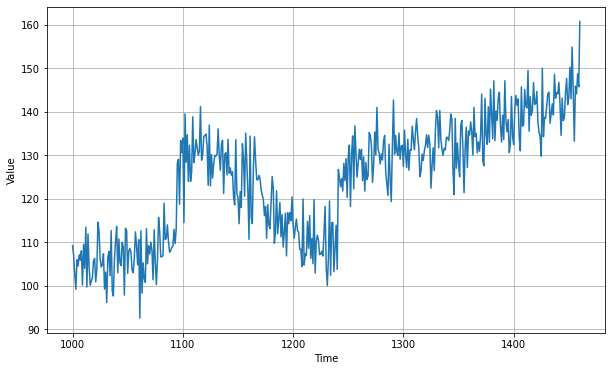

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=2, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 745.8774
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 81.5735
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 79.8692
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 78.8017
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 78.2762
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 77.1725
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 76.4887
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 75.7515
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 75.2753
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 75.1860
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 74.4997
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 74.6902
Epoch 13/100
31/31 [===

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

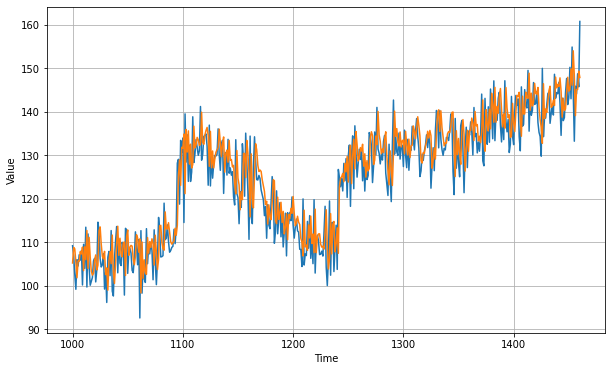

In [8]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.3107076

### Conv1D 하이퍼파라미터 튜닝

In [ ]:
!pip install keras_tuner

In [10]:
from keras_tuner.tuners import RandomSearch

In [11]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                     kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                     strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                     padding='causal', activation='relu', input_shape=[None, 1]))

    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
    model.compile(loss="mse", optimizer=sgd)
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, 
                     executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

INFO:tensorflow:Reloading Oracle from existing project my_dir/cnn-tune/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/cnn-tune/tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
kernels (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 9, 'step': 3, 'sampling': None}
strides (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 59.71597035725912
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 59.848767598470054
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 59.8813591003418
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 60.107407887776695
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 61.39033126831055
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 1
Score: 61.507301330566406
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 61.51973215738932
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
Score: 61.64185587565104
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 2
Score: 61.66156133015951
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 2
Score: 61.79896036783854


In [13]:
best_model = tuner.get_best_models(num_models=1)[0]

In [14]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

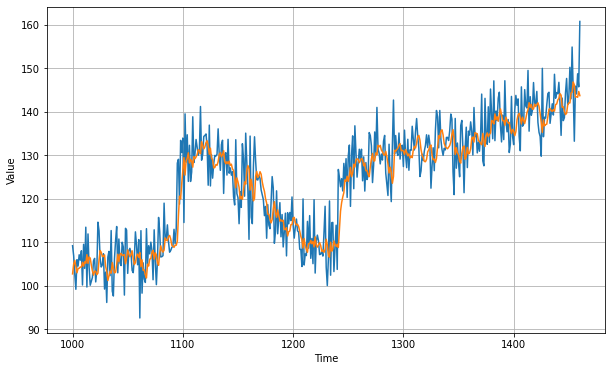

In [15]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5191154

## NASA 날씨 데이터 사용하기

### 파이썬으로 GISS 데이터 읽기

In [17]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv

--2022-03-24 09:24:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.16, 172.217.31.16, 142.250.204.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘station.csv.1’

station.csv.1       100%[===================>]   6.82K  --.-KB/s    in 0.003s  

2022-03-24 09:24:02 (2.06 MB/s) - ‘station.csv.1’ saved [6979/6979]



In [18]:
def get_station_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))
    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [19]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [20]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [21]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

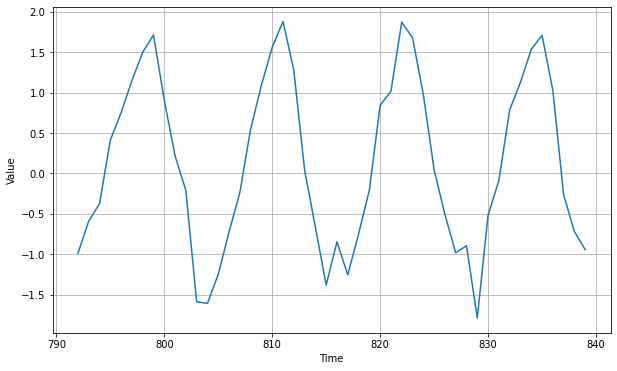

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [23]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

## RNN으로 시퀀스 모델링하기

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, 
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

In [25]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1,
                    validation_data=valid_dataset)

Epoch 1/100
64/64 [==============================] - 2s 15ms/step - loss: 0.8864 - mae: 1.3320 - val_loss: 0.9223 - val_mae: 1.3614
Epoch 2/100
64/64 [==============================] - 1s 11ms/step - loss: 0.7505 - mae: 1.1910 - val_loss: 0.7748 - val_mae: 1.2142
Epoch 3/100
64/64 [==============================] - 1s 11ms/step - loss: 0.6139 - mae: 1.0465 - val_loss: 0.6306 - val_mae: 1.0687
Epoch 4/100
64/64 [==============================] - 1s 11ms/step - loss: 0.4864 - mae: 0.9067 - val_loss: 0.4995 - val_mae: 0.9316
Epoch 5/100
64/64 [==============================] - 1s 11ms/step - loss: 0.3769 - mae: 0.7782 - val_loss: 0.3898 - val_mae: 0.8096
Epoch 6/100
64/64 [==============================] - 1s 11ms/step - loss: 0.2905 - mae: 0.6670 - val_loss: 0.3020 - val_mae: 0.7038
Epoch 7/100
64/64 [==============================] - 1s 11ms/step - loss: 0.2262 - mae: 0.5751 - val_loss: 0.2358 - val_mae: 0.6150
Epoch 8/100
64/64 [==============================] - 1s 10ms/step - loss: 0.

In [26]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

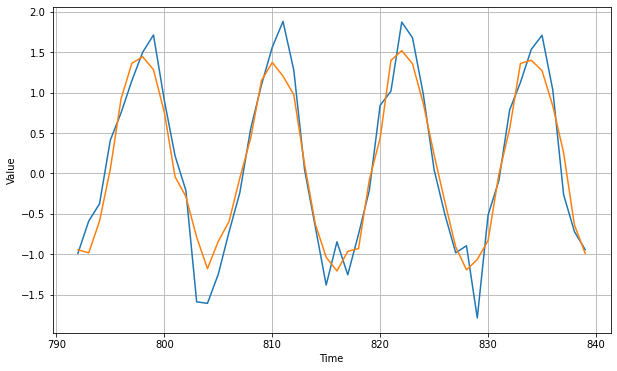

In [28]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.25711188

### 대용량 데이터셋 사용하기

In [30]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/tdaily_cet.dat.txt

--2022-03-24 09:25:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/tdaily_cet.dat.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.66.144, 142.250.199.80, 172.217.24.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.66.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728976 (1.6M) [text/plain]
Saving to: ‘tdaily_cet.dat.txt.2’

tdaily_cet.dat.txt. 100%[===================>]   1.65M  4.04MB/s    in 0.4s    

2022-03-24 09:25:14 (4.04 MB/s) - ‘tdaily_cet.dat.txt.2’ saved [1728976/1728976]



In [31]:
def get_tdaily_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [32]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [33]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
667/667 [==============================] - 27s 39ms/step - loss: 0.1261 - mae: 0.3945 - val_loss: 0.0872 - val_mae: 0.3324
Epoch 2/100
667/667 [==============================] - 26s 38ms/step - loss: 0.0844 - mae: 0.3239 - val_loss: 0.0744 - val_mae: 0.3060
Epoch 3/100
667/667 [==============================] - 25s 38ms/step - loss: 0.0760 - mae: 0.3068 - val_loss: 0.0680 - val_mae: 0.2924
Epoch 4/100
667/667 [==============================] - 25s 38ms/step - loss: 0.0712 - mae: 0.2968 - val_loss: 0.0639 - val_mae: 0.2834
Epoch 5/100
667/667 [==============================] - 26s 40ms/step - loss: 0.0680 - mae: 0.2900 - val_loss: 0.0610 - val_mae: 0.2769
Epoch 6/100
667/667 [==============================] - 26s 39ms/step - loss: 0.0656 - mae: 0.2848 - val_loss: 0.0588 - val_mae: 0.2719
Epoch 7/100
667/667 [==============================] - 26s 40ms/step - loss: 0.0639 - mae: 0.2808 - val_loss: 0.0571 - val_mae: 0.2679
Epoch 8/100
667/667 [==============================] - 

In [34]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

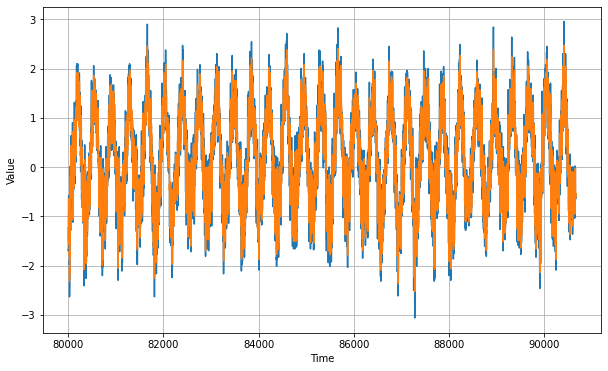

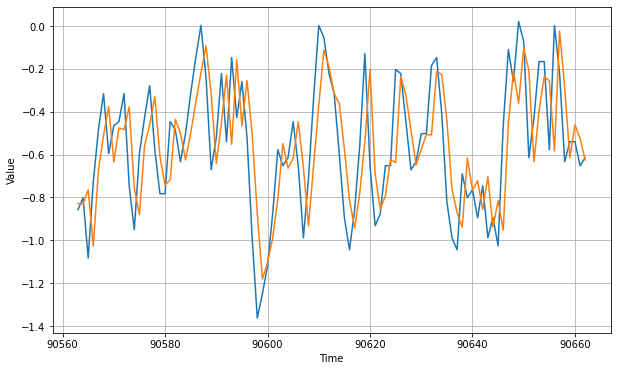

In [35]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.24228293

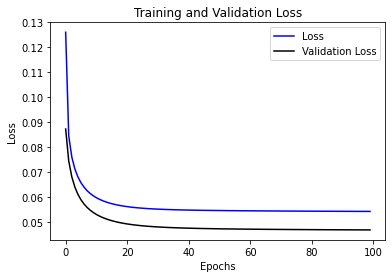

In [37]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## Dropout 사용하기

In [38]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [39]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [40]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 5s 39ms/step - loss: 0.4369 - mae: 0.8449 - val_loss: 0.4875 - val_mae: 0.9072
Epoch 2/500
64/64 [==============================] - 2s 32ms/step - loss: 0.4355 - mae: 0.8435 - val_loss: 0.4855 - val_mae: 0.9046
Epoch 3/500
64/64 [==============================] - 2s 32ms/step - loss: 0.4329 - mae: 0.8404 - val_loss: 0.4836 - val_mae: 0.9017
Epoch 4/500
64/64 [==============================] - 2s 32ms/step - loss: 0.4319 - mae: 0.8393 - val_loss: 0.4816 - val_mae: 0.8992
Epoch 5/500
64/64 [==============================] - 2s 32ms/step - loss: 0.4302 - mae: 0.8366 - val_loss: 0.4797 - val_mae: 0.8963
Epoch 6/500
64/64 [==============================] - 2s 32ms/step - loss: 0.4276 - mae: 0.8333 - val_loss: 0.4776 - val_mae: 0.8937
Epoch 7/500
64/64 [==============================] - 2s 32ms/step - loss: 0.4263 - mae: 0.8321 - val_loss: 0.4756 - val_mae: 0.8912
Epoch 8/500
64/64 [==============================] - 2s 32ms/step - loss: 0.

In [42]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

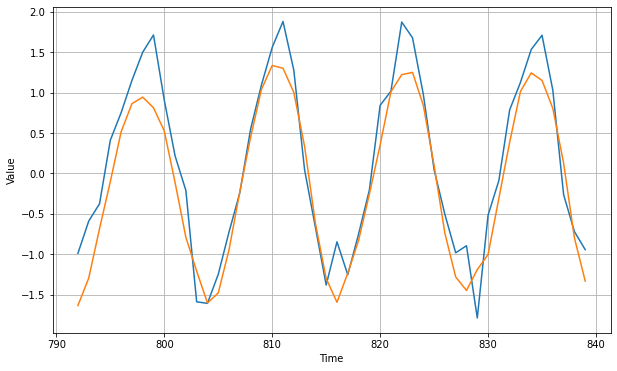

In [43]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.32171965

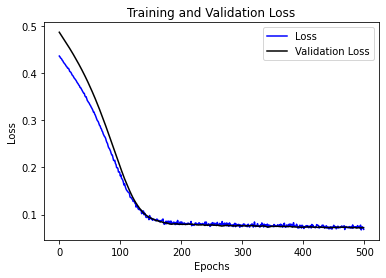

In [45]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## 양방향 RNN 사용하기

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 9s 54ms/step - loss: 0.4602 - mae: 0.8730 - val_loss: 0.5049 - val_mae: 0.9324
Epoch 2/500
64/64 [==============================] - 3s 43ms/step - loss: 0.4482 - mae: 0.8589 - val_loss: 0.4926 - val_mae: 0.9187
Epoch 3/500
64/64 [==============================] - 3s 43ms/step - loss: 0.4371 - mae: 0.8457 - val_loss: 0.4805 - val_mae: 0.9051
Epoch 4/500
64/64 [==============================] - 3s 44ms/step - loss: 0.4281 - mae: 0.8336 - val_loss: 0.4685 - val_mae: 0.8917
Epoch 5/500
64/64 [==============================] - 3s 44ms/step - loss: 0.4169 - mae: 0.8220 - val_loss: 0.4569 - val_mae: 0.8783
Epoch 6/500
64/64 [==============================] - 3s 44ms/step - loss: 0.4064 - mae: 0.8096 - val_loss: 0.4453 - val_mae: 0.8650
Epoch 7/500
64/64 [==============================] - 3s 43ms/step - loss: 0.3962 - mae: 0.7971 - val_loss: 0.4339 - val_mae: 0.8518
Epoch 8/500
64/64 [==============================] - 3s 44ms/step - loss: 0.

In [47]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

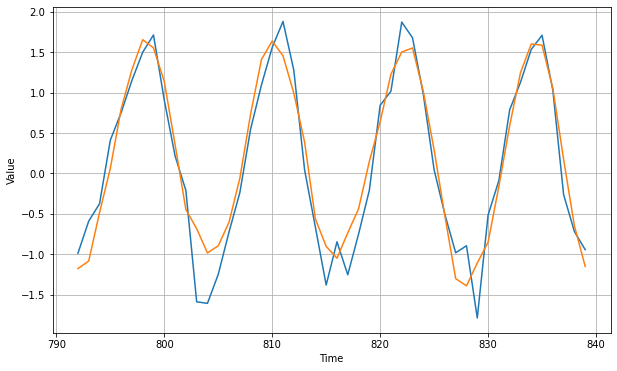

In [48]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [49]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2581081

윈도우 크기 늘려 보기

In [50]:
window_size = 40
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
63/63 [==============================] - 11s 77ms/step - loss: 0.4755 - mae: 0.8912 - val_loss: 0.5683 - val_mae: 1.0092
Epoch 2/500
63/63 [==============================] - 4s 67ms/step - loss: 0.4706 - mae: 0.8852 - val_loss: 0.5648 - val_mae: 1.0072
Epoch 3/500
63/63 [==============================] - 4s 66ms/step - loss: 0.4664 - mae: 0.8795 - val_loss: 0.5614 - val_mae: 1.0051
Epoch 4/500
63/63 [==============================] - 4s 66ms/step - loss: 0.4610 - mae: 0.8736 - val_loss: 0.5576 - val_mae: 1.0028
Epoch 5/500
63/63 [==============================] - 4s 66ms/step - loss: 0.4566 - mae: 0.8682 - val_loss: 0.5540 - val_mae: 1.0004
Epoch 6/500
63/63 [==============================] - 4s 66ms/step - loss: 0.4518 - mae: 0.8622 - val_loss: 0.5505 - val_mae: 0.9981
Epoch 7/500
63/63 [==============================] - 4s 65ms/step - loss: 0.4477 - mae: 0.8571 - val_loss: 0.5469 - val_mae: 0.9958
Epoch 8/500
63/63 [==============================] - 4s 64ms/step - loss: 0

In [52]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

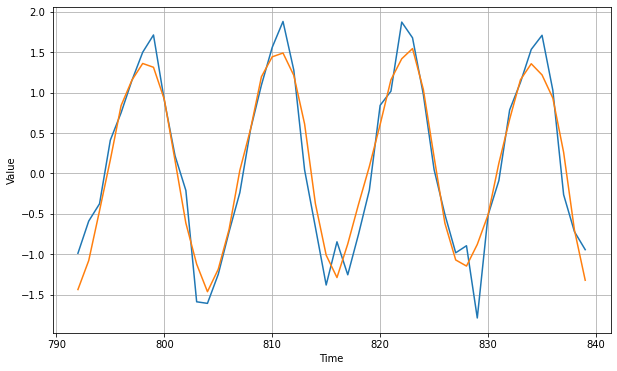

In [53]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [54]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.23638944